<a href="https://colab.research.google.com/github/tkarr21/vae-agent/blob/master/finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**VAE Agent**



Init

In [1]:

! pip3 install torch > /dev/null 2>&1
# NOTE: Code within lines of '#' are for visualization and are optional
####################
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
####################

# particle environment repo
! git clone https://github.com/tkarr21/multagent-particle-envs.git > /dev/null 2>&1

%cd /content/multagent-particle-envs
! pip3 install -e . > /dev/null 2>&1

#FIXME
# video_recorder.py capture_frame() frame = frame[0]



/content/multagent-particle-envs


In [2]:
! git pull

Already up to date.


##Dependencies and Visualization

In [3]:
import gym
import torch
import torch.nn as nn
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
from make_env import make_env

####################
# Import visualization dependencies
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


# Create a virtual display to allow visualization over Google Colab
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1200, 1200))
display.start()


class MyMonitor(Monitor):

    def _after_step(self, observation, reward, done, info):
        if not self.enabled:
            return done

        if done and self.env_semantics_autoreset:
            # For envs with BlockingReset wrapping VNCEnv, this observation
            # will be the first one of the new episode
            self._reset_video_recorder()
            self.episode_id += 1
            self._flush()

        # Semisupervised envs modify the rewards, but we want the original when
        # scoring
        if info.get('true_reward', None):
            reward = info['true_reward']

        # Record stats
        self.stats_recorder.after_step(
            observation, np.sum(reward), any(done), info)
        # Record video
        self.video_recorder.capture_frame()
        
        return done

# Show the recorded video
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

# Wrap the environment to record each frame of the episode as a video
def wrap_env(env):
  env = MyMonitor(env, './video', force=True)
  return env
####################


###Debugging environmnet

In [4]:
from make_env import make_env

env = wrap_env(make_env('simple'))

#print(env.action_space[0])

observation = env.reset() 

num_loop = 1
loop = tqdm(total=num_loop, position=0, leave=False)

for i in range(num_loop):
    for step in range(20):
        
        env.render()

        actions = []
        onehot_actions = []
        for i in range(env.n):
            if i == env.n - 1:
                role = 1
            else:
                role = 0
            action = np.random.randint(env.action_space[i].n)
            actions.append(action)
            onehot_action = np.zeros(env.action_space[i].n)
            #onehot_action[1] = 0.5

            
            #onehot_action[0] - stay    (no  p_vel)
            #onehot_action[1] - right   (- x p_vel)
            #onehot_action[2] - left    (+ x p_vel)
            #onehot_action[3] - up      (- y p_vel)
            #onehot_action[4] - down    (+ y p_vel)

            onehot_action[1] = 0.5
            #onehot_action[action] = .2 #movement rate
            onehot_actions.append(onehot_action)

        #          agent velocity    
        # state = [x p_vel, y p_vel, x p_diff, y p_diff]
        #                            differnce of physical positions 
        #                            landmark [x y] - agent [x y] 
        
        next_state, reward, done, info = env.step(onehot_actions)
        print(next_state)
        # reward = np.clip(reward, -1., 1.)
        
        
        if done[0]:
            print("Episode finished after {} timesteps".format(step + 1))
            break
        
    loop.update(1)
        

env.close()
show_video()

  0%|          | 0/1 [00:00<?, ?it/s]

[array([0.25      , 0.        , 0.11855502, 0.95583686])]
[array([0.4375    , 0.        , 0.07480502, 0.95583686])]
[array([0.578125  , 0.        , 0.01699252, 0.95583686])]
[array([ 0.68359375,  0.        , -0.05136685,  0.95583686])]
[array([ 0.76269531,  0.        , -0.12763638,  0.95583686])]
[array([ 0.82202148,  0.        , -0.20983853,  0.95583686])]
[array([ 0.86651611,  0.        , -0.29649014,  0.95583686])]
[array([ 0.89988708,  0.        , -0.38647885,  0.95583686])]
[array([ 0.92491531,  0.        , -0.47897038,  0.95583686])]
[array([ 0.94368649,  0.        , -0.57333903,  0.95583686])]
[array([ 0.95776486,  0.        , -0.66911552,  0.95583686])]
[array([ 0.96832365,  0.        , -0.76594788,  0.95583686])]


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

[array([ 0.97624274,  0.        , -0.86357216,  0.95583686])]
[array([ 0.98218205,  0.        , -0.96179036,  0.95583686])]
[array([ 0.98663654,  0.        , -1.06045402,  0.95583686])]
[array([ 0.9899774 ,  0.        , -1.15945176,  0.95583686])]
[array([ 0.99248305,  0.        , -1.25870006,  0.95583686])]
[array([ 0.99436229,  0.        , -1.35813629,  0.95583686])]
[array([ 0.99577172,  0.        , -1.45771346,  0.95583686])]
[array([ 0.99682879,  0.        , -1.55739634,  0.95583686])]


##Modules

###Encoder, Decoder, VAE

In [5]:
class Encoder(nn.Module):
  def __init__(self, state_size, latent_dim):
    """Fully connected network to mu and sigma 

      args:
      state_size - number of incoming state variables from environment
      latent_dim - number of dimensions of the latent space
    """

    super().__init__()

    hidden_size = 8
    
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size))
    
    #mu
    self.g = nn.Linear(hidden_size, latent_dim)

    #sigma
    self.h = nn.Linear(hidden_size, latent_dim)


  def forward(self, x):
    """ Encode input to latent space
    """

    out = self.net(x)

    return self.g(out), self.h(out)



class Decoder(nn.Module):
  def __init__(self, latent_dim, action_size, device='cpu'):
    """ vanilla fully connected network

      args:
      action_size - number of available actions to agent
      latent_dim - number of dimensions of the latent space
    """
    super().__init__()

    self.device = device
    hidden_size = 8
    self.latent_dim = latent_dim
    
    self.net = nn.Sequential(nn.Linear(latent_dim, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size),
                             nn.Softmax(dim=1))


  def forward(self, mean, var):
    """ decode from latent space

        args:
        mean - tensor of 
    """
    # sample trick
    zeta = torch.randn(self.latent_dim).to(self.device) # requires_grad=False by default
    z = var * zeta + mean
    
    return self.net(z)




class VAE(nn.Module):
  def __init__(self, state_size, action_size, latent_dim, device='cpu'):
    super().__init__()

    self.encoder = Encoder(state_size, latent_dim)
    self.decoder = Decoder(latent_dim, action_size, device)


  def forward(self, x):

    mu, sigma = self.encoder(x)
    return self.decoder(mu, sigma)



##Lab 10 code

https://colab.research.google.com/drive/1-xU1-32NgYYT7dL4KCtAe4IeySHfbGHu?usp=sharing

Changes:
- multiagent particle environment

- replace policy network with VAE

- some adjustments for passing the "state" "next_state" variables

###Value Network/Dataset wrapper

In [6]:
# Dataset that wraps memory for a dataloader
class RLDataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = []
    for d in data:
      self.data.append(d)
  
  def __getitem__(self, index):
    return self.data[index]
 
  def __len__(self):
    return len(self.data)

    

# Value Network
class ValueNetwork(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    hidden_size = 8
  
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))
    
  def forward(self, x):
    """Estimate value given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          value (tensor): estimated value, size (batch)
    """
    return self.net(x)

###Helper Functions


In [7]:
device = 'cpu'

def calculate_return(memory, rollout, gamma):
  """Return memory with calculated return in experience tuple

    Args:
        memory (list): (state, action, action_dist, return) tuples
        rollout (list): (state, action, action_dist, reward) tuples from last rollout
        gamma (float): discount factor

    Returns:
        list: memory updated with (state, action, action_dist, return) tuples from rollout
  """

  retval = 0
  for state, action, action_dist, reward in reversed(rollout):
    retval = reward + retval * gamma 
    memory.append((state, action, action_dist, retval))

  return memory

def get_action_ppo(network, state):
  """Sample action from the distribution obtained from the policy network

    Args:
        network (PolicyNetwork): Policy Network
        state (np-array): current state, size (state_size)

    Returns:
        int: action sampled from output distribution of policy network
        array: output distribution of policy network
  """

  with torch.no_grad():
    a_dist = network(torch.tensor(state, dtype=torch.float).to(device).unsqueeze(0))


    a_detached = a_dist.cpu().detach().numpy()[0].astype(np.float64)#to(device)

    a_detached = a_detached / np.linalg.norm(a_detached, ord=1, keepdims=True)
  

    random_action = np.argmax(np.random.multinomial(1, a_detached))
    
    return random_action, a_dist


In [8]:
def learn_ppo(optim, policy, value, memory_dataloader, epsilon, policy_epochs):

  for _ in range(policy_epochs):
    for state, action, action_dist, retval in memory_dataloader:
      optim.zero_grad()

      state = state.float().to(device)
      retval = retval.to(device)

      estimated_return = retval - value(state).squeeze(1)

      v_loss = (estimated_return**2).mean()

      advantage = estimated_return
      advantage = advantage.detach()
      current_action_dist = policy(state)

      cur_prob = current_action_dist.squeeze(1)[range(current_action_dist.shape[0]), action]
      old_prob = action_dist.squeeze(1)[range(action_dist.shape[0]), action]

      ratio = cur_prob / old_prob

      left = ratio * advantage
      right = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantage

      p_loss = torch.min(left,right)
      p_loss = -torch.mean(p_loss)

      loss = p_loss + v_loss

      # was missing v_loss
      v_loss.backward()
      p_loss.backward()
      optim.step()

##Main


In [9]:
def ppo_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 50
  env_samples = 100
  gamma = 0.9   #TODO .99
  batch_size = 256
  epsilon = 0.2
  policy_epochs = 5
  latent_dim = 5  #TODO 1+
  movement_rate = .2

  # Init environment 
  state_size = 4
  action_size = 5
  

  #env = gym.make('CartPole-v1')
  env = make_env('simple')

  # Init networks
  #policy_network = PolicyNetwork(state_size, action_size).to(device)
  policy_network = VAE(state_size, action_size, latent_dim, device).to(device)
  value_network = ValueNetwork(state_size).to(device)

  # Init optimizer
  optim = torch.optim.Adam(chain(policy_network.parameters(), value_network.parameters()), lr=lr)

  # Start main loop
  results_ppo = []
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    
    ######################
    # Wrap environment to record a video of the last training episode
    last_epoch = (epoch+1 == epochs)
    if last_epoch:
      env = wrap_env(env)
    ######################
    
    memory = []  # Reset memory every epoch
    rewards = []  # Calculate average episodic reward per epoch

    # Begin experience loop
    for episode in range(env_samples):
      
      # Reset environment
      state = env.reset()
      state = state[0]

      done = False
      rollout = []
      cum_reward = 0  # Track cumulative reward
      reward = 10
      time_out = 0

      # Begin episode
      while reward != 0 and time_out < 200: #not done and cum_reward < 200:  # End after 200 steps   

        time_out += 1

        # Get action
        action, action_dist = get_action_ppo(policy_network, state)


        # one hot encode and put in a list for multi agent env
        onehot_action = np.zeros(env.action_space[0].n)
        onehot_action[action] = movement_rate

        onehot_actions = []
        onehot_actions += [onehot_action]



        # Take step
        next_state, reward, done, _ = env.step(onehot_actions)

        next_state = next_state[0]
        reward = reward[0]
        done = done[0]

        # env.render()

        # Store step
        rollout.append((state, action, action_dist, reward))

        cum_reward += reward
        state = next_state  # Set current state

        
      # Calculate returns and add episode to memory
      memory = calculate_return(memory, rollout, gamma)

      rewards.append(cum_reward)
    
      ######################
      # If the environment is not manually closed, resetting it could throw an error
      env.close()
      ######################
      
    # Train
    dataset = RLDataset(memory)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    learn_ppo(optim, policy_network, value_network, loader, epsilon, policy_epochs)
    
    # Print results
    results_ppo.extend(rewards)  # Store rewards for this epoch
    loop.update(1)
    loop.set_description("Epochs: {} Reward: {}".format(epoch, results_ppo[-1]))

  return results_ppo, policy_network

results_ppo, vae = ppo_main()

Epochs: 49 Reward: -84.19183345400793: 100%|██████████| 50/50 [08:55<00:00, 11.68s/it]

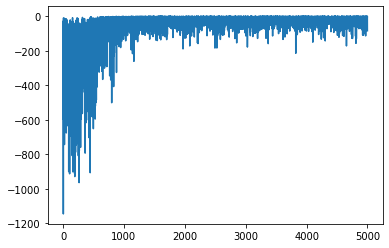

In [10]:
plt.plot(results_ppo)
plt.show()

######################
# Display the video of the last training episode
show_video()
######################

### VAE visualization

state: [  0.   0. 100.   0.]


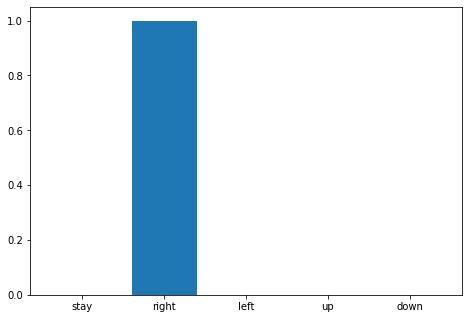

state: [ 0.    0.   70.71 70.71]


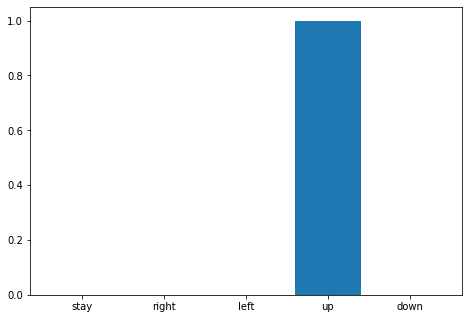

state: [  0.   0.   0. 100.]


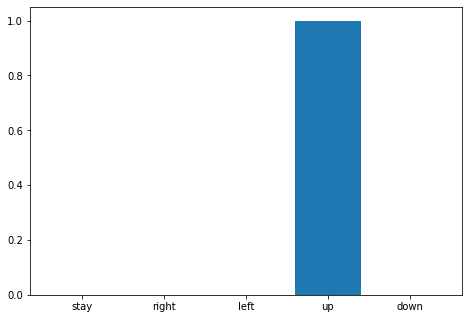

state: [  0.     0.   -70.71  70.71]


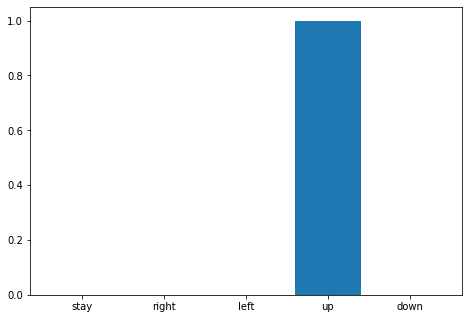

state: [   0.    0. -100.    0.]


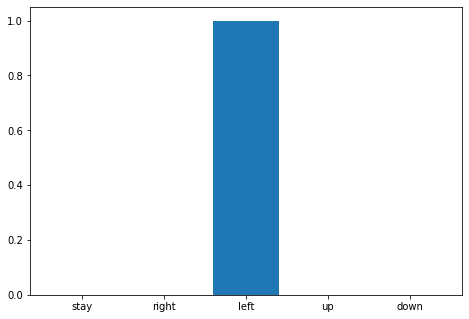

state: [  0.     0.   -70.71 -70.71]


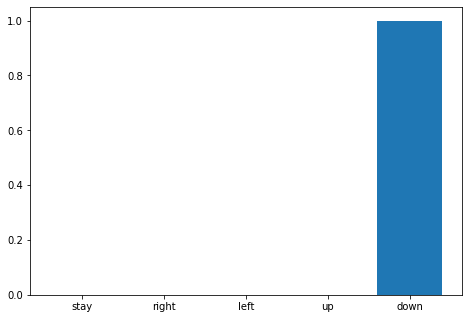

state: [   0.    0.   -0. -100.]


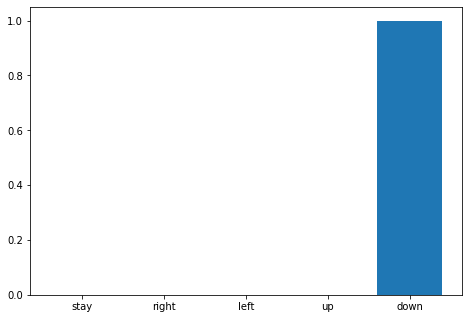

state: [  0.     0.    70.71 -70.71]


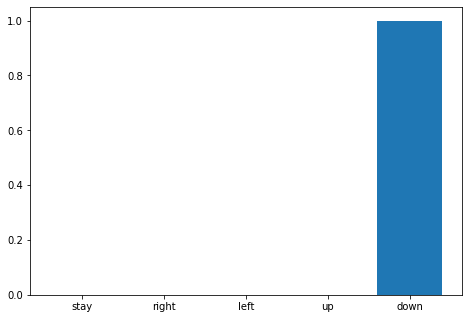

In [11]:
from math import cos, sin, radians

def point_on_circle(radius, degrees):
  '''
      Finding the x,y coordinates on circle, based on given angle
  '''
  
  #center of circle, angle in degree and radius of circle
  center = [0,0]
  angle = radians(degrees)
  #x = offsetX + radius * Cosine(radians)
  x = center[0] + (radius * cos(angle))
  #y = offsetY + radius * Sine(radians)
  y = center[1] + (radius * sin(angle))

  return [round(x,2), round(y,2)]

# set of states we want to visualize
# velocities will be zero..

radius = 100
states = [np.array([0, 0, *point_on_circle(radius,i)]) for i in range(0, 360, 45)]

# visualize state with respective action distribution

for s in states:
  a_dist = get_action_ppo(vae, s)
  a_dist = a_dist[1].cpu().numpy()[0]
  print("state: {}".format(s))
  #print("a_dist: {}".format(a_dist[1]))


  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  moves = ["stay", "right", "left",  "up", "down"]

  ax.bar(moves,a_dist)
  plt.show()



Unit circle ![alt text](https://wumbo.net/unit-circle-chart/unit-circle-chart.png)